In [1]:
%matplotlib inline 
from IPython.display import display
import os
import subprocess
import requests
import datetime
import xarray as xr
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

/home/santi/.miniconda3/envs/camalot/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def fetch_smn_data(from_date, to_date, output_dir):
    """
    Fetch meteorological data from SMN
    """
    if from_date < datetime.datetime(2017, 11, 26):
        raise ValueError("No data before 2017-11-26")
    files = _download_smn_data(from_date, to_date, output_dir)
    dataframes = []
    for file in files:
        csv_file = _convert_to_csv(file)
        dataframes.append(pd.read_csv(csv_file))
    df = pd.concat(dataframes, ignore_index=True)
    _convert_datetime(df)
    # Convert Temperature to K
    df.temp += 273.15
    # Convert pressure to Pa
    df.pressure *= 1e2
    # Convert time to UTC
    df.time += datetime.timedelta(hours=3)
    # Drop nans
    df.dropna(how="any", inplace=True)
    return df


def _convert_to_csv(filename):
    """
    """
    filename_csv = filename.replace(".txt", ".csv") 
    content = "date,hour,temp,humidity,pressure,wind_dir,wind_speed,station\n"
    with open(filename, "rb") as f:
        for i, line in enumerate(f):
            if i < 2:
                continue
            line = line.decode('latin-1').strip()
            content += line[:8].strip() + ","
            content += line[8:14].strip() + ","
            content += line[14:20].strip() + ","
            content += line[20:25].strip() + ","
            content += line[25:33].strip() + ","
            content += line[33:38].strip() + ","
            content += line[38:43].strip() + ","
            content += line[43:].strip() + "\n"
    with open(filename_csv, 'w') as f:
        f.write(content)
    return filename_csv


def _convert_datetime(df):
    datetimes = []
    for i in range(len(df)):
        date = df.date[i]
        hour = df.hour[i]
        if np.isnan(hour):
            datetimes.append(np.nan)
        else:
            hour = int(hour)
            day, month, year = int(str(date)[:2]), int(str(date)[2:4]), int(str(date)[4:])
            datetimes.append(datetime.datetime(year, month, day, hour))
    df["time"] = datetimes
    del df["hour"]
    del df["date"]

def _download_smn_data(from_date, to_date, output_dir):
    """
    Download meteorological data from SMN
    """
    base_url = "https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=observaciones/"
    day_interval = datetime.timedelta(days=1)
    files = []
    date = from_date
    while True:
        if date > to_date:
            break
        filename = "datohorario{:d}{:02d}{:02d}.txt".format(date.year, date.month, date.day)
        file_path = os.path.join(output_dir, filename)
        if not os.path.isfile(file_path):
            response = requests.get(base_url + filename)
            with open(file_path, "wb") as f:
                f.write(response.content)
        files.append(file_path)
        date += day_interval
    return files

In [3]:
output_dir = os.path.join("data", "smn")
from_date = datetime.datetime(2017, 11, 28)
to_date = datetime.datetime(2019, 11, 18)

df = fetch_smn_data(from_date, to_date, output_dir)

In [4]:
sj_aero = df.station == "SAN JUAN AERO"
sj = df[sj_aero]
sj = sj.set_index("time")

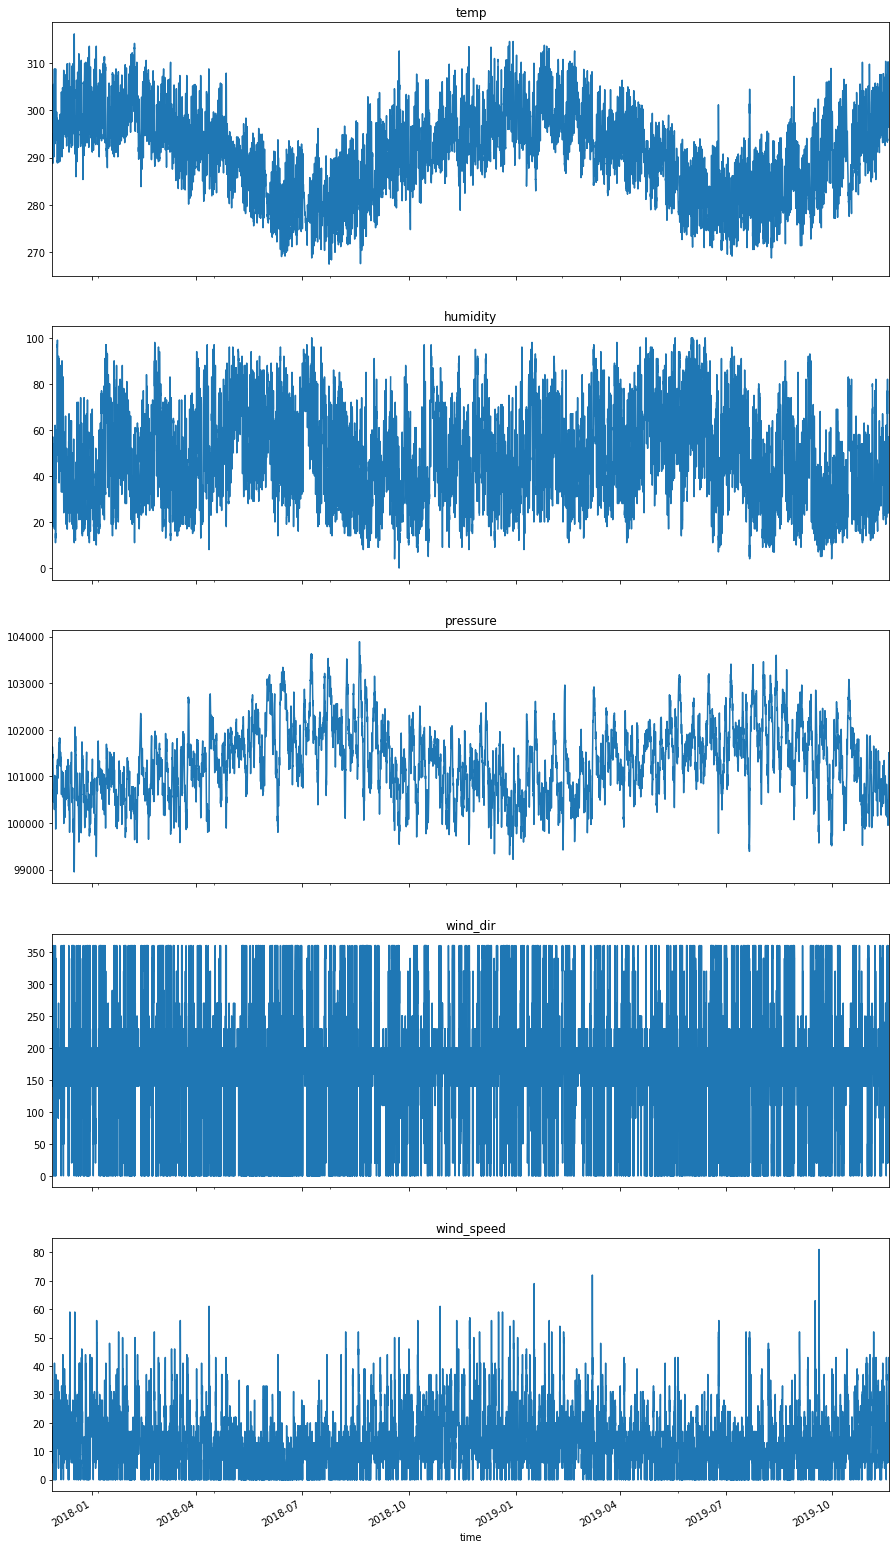

In [5]:
variables = [var for var in sj if var != "station"]

fix, axes = plt.subplots(
    ncols=1, nrows=len(variables), sharex=True, figsize=(15, 6*len(variables))
)
for ax, variable in zip(axes, variables):
    getattr(sj, variable).plot(ax=ax)
    ax.set_title(variable)
plt.show()

In [6]:
sj.to_csv(os.path.join("data", "san_juan_airport_data.csv"))